# Plotting Temperature and Cyanobacteria (phylum) reads, bacterias that obtain their energy through photosynthesis, normalised by number of InterPro annotations, for Tara Oceans project PRJEB1787.

The following task shows how to analysie metadata and annotations retrieved from the EMG API and combined on the fly to generate the visualisations.

In [1]:
import copy
try:
    from urllib import urlencode
except ImportError:
    from urllib.parse import urlencode
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from jsonapi_client import Session, Filter

API_BASE = 'https://www.ebi.ac.uk/metagenomics/api/latest/'

List all runs
https://www.ebi.ac.uk/metagenomics/api/latest/runs?experiment_type=metagenomic&study_accession=PRJEB1787

In [3]:
def find_metadata(metadata, key):
    """
    Extract metadata value for given key
    """
    for m in metadata:
        if m['key'].lower() == key.lower():
            return m['value']
    return None


metadata_key = 'temperature'
normilize_key = 'Predicted CDS with InterProScan match'

# map GO terms to the temperature
result = {}


with Session(API_BASE) as s:

    # temporary dict to store accession and metadata
    metadata_map = {}
    # list of runs missing metadata
    missing_meta = list()
    
    print('Loading data from API.', end='', flush=True)

    # preparing url
    params = {
        'experiment_type': 'metagenomic',
        'study_accession': 'ERP001736',
        'page_size': 100,
        'include': 'sample',
    }
    f = Filter(urlencode(params))
    # list runs
    for anls in s.iterate('analyses', f):
        print('.', end='', flush=True)

        # find temperature for each run
        try:
            m_value = float(find_metadata(anls.sample.sample_metadata, metadata_key))
        except:
            m_value = None
        if m_value is not None:
            metadata_map[anls.accession] = m_value
        else:
            # missing value, skip run!
            missing_meta.append(anls.accession)
            continue

        _pcds = int(find_metadata(anls.analysis_summary, normilize_key))
        if _pcds is None:
            # missing value, skip run!
            continue

        _temperature = metadata_map[anls.accession]
        try:
            result[_temperature]
        except KeyError:
            result[_temperature] = {}

        # list a summary of GO terms derived from InterPro matches
        for ann in anls.taxonomy:
            try:
                ann.hierarchy['phylum']
            except KeyError:
                continue
            if len(ann.hierarchy['phylum']) > 0:
                l = "{}:{}".format(ann.hierarchy['kingdom'], ann.hierarchy['phylum'])
                try:
                    result[_temperature][l]
                except KeyError:
                    result[_temperature][l] = list()
                # normalize annotation counts, adjusting value
                _norm = int(ann.count)/_pcds
                # assign value
                result[_temperature][l].append(_norm)
            

    print("DONE")
    # print("Missing: ", missing_meta)

Loading data from API..........................................................................................................................................................................................................................................................DONE


### Clean up data

In [4]:
# remove invalid temperatures
for k in copy.deepcopy(list(result.keys())):
    if k > 1000:
        del result[k]
# average value of the same temperature
for k in result:
    for k1 in result[k]:
        result[k][k1] = np.mean(result[k][k1])

### Calculate correlation

In [5]:
from scipy.stats import spearmanr
df = DataFrame(result)
df_go = df.T[['Bacteria:Cyanobacteria']].copy()
x = df_go.index.tolist()
correl = []
correl_p = []
for k in df_go.keys():
    y = list(df_go[k])
    rho, p = spearmanr(x, y)

    correl.append(rho)
    correl_p.append(p)
df_go.loc['rho'] = correl
df_go.loc['p'] = correl_p

In [6]:
df_go

,Bacteria:Cyanobacteria
-0.78154,2.040291e-05
0.45883,1.175759e-06
0.67108,1.528409e-05
1.84402,1.648750e-05
4.216697,2.292086e-07
4.673875,8.474752e-06
4.749588,1.632780e-07
4.936634,1.798967e-07
5.067239,1.220466e-07
5.791448,2.191975e-07


### Plot

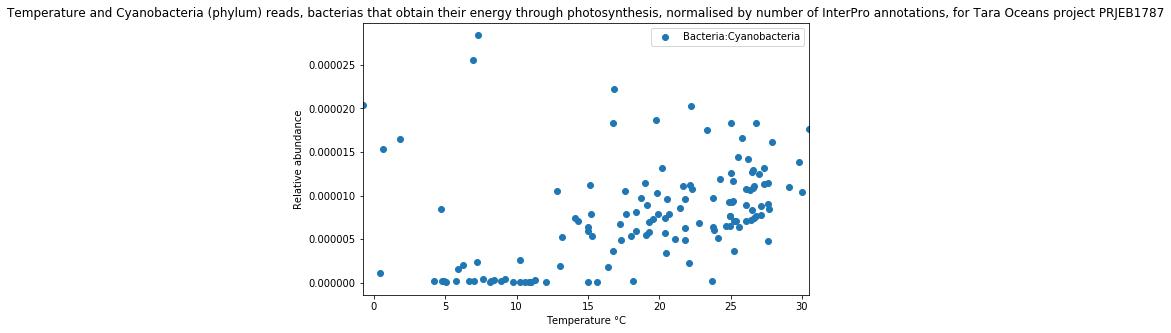

In [7]:
df = DataFrame(result)
df_go_plot = df.T[['Bacteria:Cyanobacteria']].copy()

pl = df_go_plot.plot(
    y=['Bacteria:Cyanobacteria'], use_index=True, style='o', figsize=(8,5),
    title='Temperature and Cyanobacteria (phylum) reads, bacterias that obtain their energy through photosynthesis, normalised by number of InterPro annotations, for Tara Oceans project PRJEB1787',
)
pl.set_xlabel("Temperature °C")
# pl.set_xlabel("Depth m")
pl.set_ylabel("Relative abundance")

plt.show()